In [1]:
import tensorflow.keras as keras
from tensorflow.keras import initializers,regularizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Concatenate
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K
import math
import matplotlib.pylab as plt
import matplotlib
from random import random

In [2]:
import numpy as np
import pandas as pd

In [3]:
def new_df(df,mass):
    df['mass'] = [mass for i in range(len(df))]
    df['log_energy'] = np.log10(df['energy'])
    df['cos_zenith'] = np.cos(df['zenith'])
    df['log_energy_loss'] = np.log10(df['energy_loss'])
    df['log_xmax'] = np.log(df['Xmax'])
    df = df.loc[(df['Xmax']<900)&(df['Xmax']>400)&(df['m_chi2']!=0)&(df['s_chi2']!=0)&(df['m_chi2']<2)&(df['s_chi2']<2)]
    return df

In [4]:
iron = pd.read_csv('Iron.csv')
proton = pd.read_csv('Proton.csv')
#helium = pd.read_csv('Helium.csv')
#oxygen = pd.read_csv('Oxygen.csv')

In [5]:
iron.keys()

Index(['Unnamed: 0', 'mass', 'energy', 'zenith', 'S125', 'energy_loss',
       'he_stoch', 'he_stoch2', 'Xmax', 'A', 'm_125', 'm_z', 'm_r', 'm_o',
       'm_chi2', 's_125', 's_z', 's_r', 's_o', 's_mix', 's_chi2'],
      dtype='object')

In [6]:
iron = new_df(iron,4)
proton = new_df(proton,1)
#helium = new_df(helium,2)
#oxygen = new_df(oxygen,3)

/home/andy/.local/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/andy/.local/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
df = iron.append(proton)
#df = df.append(helium)
#df = df.append(oxygen)

In [8]:
df['log_energy'] = df['log_energy'].values

In [9]:
df.head()

,Unnamed: 0,mass,energy,zenith,S125,energy_loss,he_stoch,he_stoch2,Xmax,A,...,s_125,s_z,s_r,s_o,s_mix,s_chi2,log_energy,cos_zenith,log_energy_loss,log_xmax
1,1,4,10826061.0,0.508086,0.907269,NaN,NaN,NaN,477.023376,0.000172,...,4.557713,0.020636,0.122279,-7.509688,-3.079320e-04,0.225366,7.03447,0.873677,NaN,6.167565
2,2,4,10826061.0,0.503435,0.892701,NaN,NaN,NaN,477.023376,0.000215,...,3.036345,0.038314,0.567552,-51.097699,-4.210312e-04,0.560012,7.03447,0.875930,NaN,6.167565
3,3,4,10826061.0,0.512100,0.915605,NaN,NaN,NaN,477.023376,0.000775,...,0.794777,-0.000764,0.000105,0.959791,2.032333e-07,0.033513,7.03447,0.871717,NaN,6.167565
4,4,4,10826061.0,0.504864,0.911405,NaN,NaN,NaN,477.023376,0.000370,...,1.415908,0.043345,0.084347,-3.850656,-7.857305e-04,0.004969,7.03447,0.875240,NaN,6.167565
5,5,4,10826061.0,0.510181,0.840283,NaN,NaN,NaN,477.023376,0.000731,...,5.226838,0.003506,-0.030455,2.302172,2.668582e-04,0.576149,7.03447,0.872656,NaN,6.167565


In [10]:
check = [math.isnan(i)==0 for i in df['energy_loss'].values]

In [11]:
df_coinc = df[check]

In [12]:
check2 = [i==0 for i in np.isnan(df_coinc['log_energy_loss'].values)]
df_coinc = df_coinc.loc[check2]

In [13]:
df_coinc.keys()

Index(['Unnamed: 0', 'mass', 'energy', 'zenith', 'S125', 'energy_loss',
       'he_stoch', 'he_stoch2', 'Xmax', 'A', 'm_125', 'm_z', 'm_r', 'm_o',
       'm_chi2', 's_125', 's_z', 's_r', 's_o', 's_mix', 's_chi2', 'log_energy',
       'cos_zenith', 'log_energy_loss', 'log_xmax'],
      dtype='object')

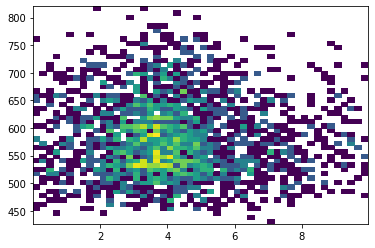

In [30]:
plt.hist2d(df_coinc['m_125'].values[(df_coinc['m_125']>0)&(df_coinc['m_125']<10)],df_coinc['Xmax'].values[(df_coinc['m_125']>0)&(df_coinc['m_125']<10)],bins=50,norm =matplotlib.colors.LogNorm() )
plt.show()

In [15]:
np.mean(iron['m_125']),np.mean(proton['m_125'])

(3.733046095739403, 3.270127529187203)

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
y = df_coinc[['mass','log_energy']].values
X = df_coinc[['cos_zenith','S125','log_energy_loss','he_stoch','he_stoch2','m_r','s_r','m_o','s_o','m_125','s_125','s_z','m_z']].values

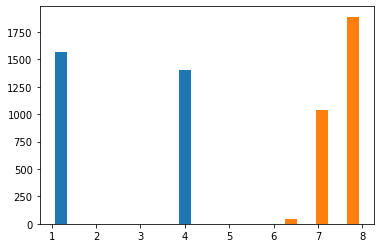

In [18]:
plt.hist(y)
plt.show()

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
weight = []
for i in y_train:
    if i[0] == 1:
        weight.append(1)
    elif i[0] == 2:
        weight.append(1)
    elif i[0] == 3:
        weight.append(1)
    else:
        weight.append(1)

In [21]:
model_best = 'model_coinc_best.h5'

best_model = keras.callbacks.ModelCheckpoint(model_best,
                                             monitor='val_loss',
                                             save_best_only=True,
                                             save_weights_only=False,
                                             mode='auto')

input_layer = Input(shape=(13,))

model1 = Dense(7,activation='relu')(input_layer)

model1 = Dropout(rate=0.1)(model1)

model2 = Dense(4,activation='relu')(model1)

model3 = Concatenate(axis=-1)([input_layer,model1,model2])

predictions = Dense(2,activation='linear')(model3)

model = Model(inputs=input_layer,outputs=predictions)

opt = keras.optimizers.RMSprop(decay=1e-5)

model.compile(optimizer=opt , loss = 'mse')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [22]:
history = model.fit(X_train,y_train,
                    epochs=500,
                    validation_data = (X_test,y_test),
                    callbacks=[best_model],
                    class_weight = weight)

Train on 2376 samples, validate on 594 samples
Epoch 1/500
2376/2376 [==============================] - 0s 137us/sample - loss: 434680.0400 - val_loss: 1246299.3800
Epoch 2/500
2376/2376 [==============================] - 0s 36us/sample - loss: 373911.3393 - val_loss: 1062940.0167
Epoch 3/500
2376/2376 [==============================] - 0s 34us/sample - loss: 365476.1910 - val_loss: 873489.4859
Epoch 4/500
2376/2376 [==============================] - 0s 37us/sample - loss: 196812.0990 - val_loss: 516737.4151
Epoch 5/500
2376/2376 [==============================] - 0s 35us/sample - loss: 197528.4828 - val_loss: 393540.1309
Epoch 6/500
2376/2376 [==============================] - 0s 36us/sample - loss: 105050.7601 - val_loss: 247632.2184
Epoch 7/500
2376/2376 [==============================] - 0s 35us/sample - loss: 119596.3914 - val_loss: 177706.6752
Epoch 8/500
2376/2376 [==============================] - 0s 36us/sample - loss: 56231.4128 - val_loss: 133802.1168
Epoch 9/500
2376/2376 [

KeyboardInterrupt: 

In [90]:
best_model = load_model('model_coinc_best.h5')

In [91]:
predictions = best_model.predict(X_test)

In [92]:
mass = np.array(list(zip(*y_test))[0])

In [93]:
energy = np.array(list(zip(*y_test))[1])
energy_predictions = np.array(list(zip(*predictions))[1])

In [94]:
import matplotlib

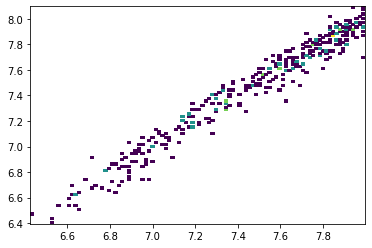

In [95]:
plt.hist2d(energy,list(zip(*predictions))[1],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

In [96]:
check = (energy_predictions>=0)

In [97]:
predictions = predictions[check]

In [98]:
mass = mass[check]

In [99]:
iron_prediction = np.array(list(zip(*predictions[mass == 4]))[0])
proton_prediction = np.array(list(zip(*predictions[mass==1]))[0])
#helium_prediction = np.array(list(zip(*predictions[mass==2]))[0])
#oxygen_prediction = np.array(list(zip(*predictions[mass==3]))[0])

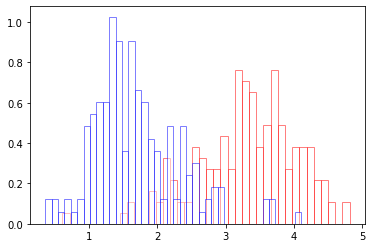

In [103]:
hist1 = plt.hist(iron_prediction[iron_prediction>=0],bins=40,facecolor='w',edgecolor='r',alpha=0.5,density=True)
hist2 = plt.hist(proton_prediction[proton_prediction>=0],bins=40,facecolor='w',edgecolor='b',alpha=0.5,density=True)
#hist3 = plt.hist(helium_prediction[helium_prediction>=0],bins=100,facecolor='w',edgecolor='g',alpha=0.5,density=True)
#hist4 = plt.hist(oxygen_prediction[oxygen_prediction>=0],bins=100,facecolor='w',edgecolor='orange',alpha=0.5,density=True)
plt.show()

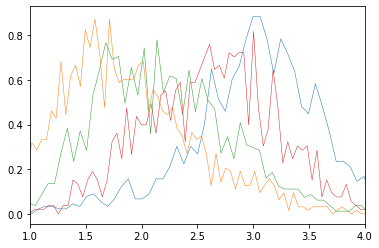

In [253]:
plt.plot(hist1[1][0:-1],hist1[0],linewidth=0.5)
plt.plot(hist2[1][0:-1],hist2[0],linewidth=0.5)
plt.plot(hist3[1][0:-1],hist3[0],linewidth=0.5)
plt.plot(hist4[1][0:-1],hist4[0],linewidth=0.5)
plt.xlim(1,4)
plt.savefig('second_attempt_energy_limited.png')

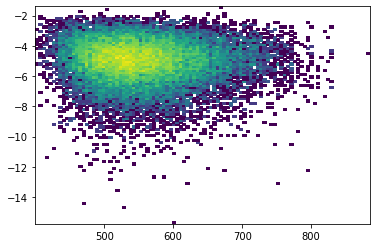

In [174]:
plt.hist2d(df_coinc['Xmax'],np.log(abs(df_coinc['m_r']-np.mean(df_coinc['m_r']))),bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

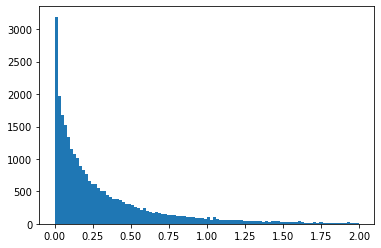

In [74]:
plt.hist(df_coinc['m_chi2'][df_coinc['m_chi2']<2],bins=100)
plt.show()

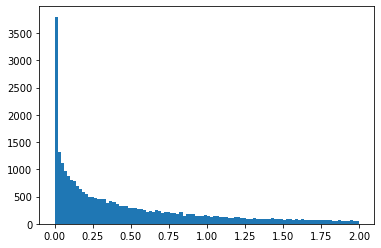

In [175]:
plt.hist(df_coinc['s_chi2'][df_coinc['s_chi2']<2],bins=100)
plt.show()